In [4]:
import pandas as pd

mob_15_20 = pd.read_csv("../data/LFB_Mobilisation_2015_2020_clean.csv", low_memory=False)
mob_21_24 = pd.read_csv("../data/LFB_Mobilisation_2021_2024.csv", low_memory=False)

print("2015–2020 :", mob_15_20.shape)
print("2021–2024 :", mob_21_24.shape)
mob_21_24.head()

2015–2020 : (883641, 23)
2021–2024 : (727747, 24)


,IncidentNumber,CalYear,BoroughName,WardName,HourOfCall,ResourceMobilisationId,Resource_Code,PerformanceReporting,DateAndTimeMobilised,DateAndTimeMobile,...,DateAndTimeLeft,DateAndTimeReturned,DeployedFromStation_Code,DeployedFromStation_Name,DeployedFromLocation,PumpOrder,PlusCode_Code,PlusCode_Description,DelayCodeId,DelayCode_Description
0,000004-01012021,2021,HARINGEY,Muswell Hill,0,5769249,A321,1,01/01/2021 00:06,01/01/2021 00:07,...,01/01/2021 00:57,NaN,A32,Hornsey,Home Station,1,Initial,Initial Mobilisation,NaN,NaN
1,000005-01012021,2021,REDBRIDGE,MONKHAMS,0,5769250,F351,1,01/01/2021 00:07,01/01/2021 00:09,...,01/01/2021 00:18,NaN,F35,Woodford,Home Station,1,Initial,Initial Mobilisation,NaN,NaN
2,000006-01012021,2021,BARKING AND DAGENHAM,Village,0,5769251,F412,1,01/01/2021 00:08,01/01/2021 00:10,...,01/01/2021 00:24,NaN,F41,Dagenham,Home Station,1,Initial,Initial Mobilisation,12.0,Not held up
3,000007-01012021,2021,WANDSWORTH,West Hill,0,5769252,H331,1,01/01/2021 00:12,01/01/2021 00:13,...,01/01/2021 00:40,NaN,H33,Wandsworth,Home Station,1,Initial,Initial Mobilisation,8.0,Traffic calming measures
4,000007-01012021,2021,WANDSWORTH,West Hill,0,5769253,G351,2,01/01/2021 00:12,01/01/2021 00:13,...,01/01/2021 00:29,NaN,G35,Fulham,Home Station,2,Initial,Initial Mobilisation,NaN,NaN


In [16]:
import os

figures_dir = "../figures"
os.makedirs(figures_dir, exist_ok=True)

def savefig(name, dpi=300):
    """
    Sauvegarde le graphique courant dans le dossier ../figures
    name : str -> nom du fichier (ex: 'graphique1.png')
    dpi : résolution de l'image (par défaut 300 pour impression)
    """
    path = os.path.join(figures_dir, name)
    plt.savefig(path, dpi=dpi, bbox_inches="tight")
    print(f"✅ Figure sauvegardée : {path}")

In [6]:
# On compare les colonnes des deux datasets. Cela permet de prevoir les etapes de nettoyage du second df.

set_15_20 = set(mob_15_20.columns)
set_21_24 = set(mob_21_24.columns)

print("Colonnes présentes uniquement dans 2015–2020 :", sorted(set_15_20 - set_21_24))
print("Colonnes présentes uniquement dans 2021–2024 :", sorted(set_21_24 - set_15_20))

Colonnes présentes uniquement dans 2015–2020 : ['Cancelled', 'DayPeriod', 'Season']
Colonnes présentes uniquement dans 2021–2024 : ['BoroughName', 'PlusCode_Code', 'PlusCode_Description', 'WardName']


In [7]:
import matplotlib.pyplot as plt

# Colonnes minimales pour l'analyse de performance
colonnes_clefs = [
    "IncidentNumber",
    "DeployedFromStation_Name",  # sera renommée en StationName
    "TurnoutTimeSeconds",
    "TravelTimeSeconds",
    "AttendanceTimeSeconds",
    "DelayCode_Description",
    "PerformanceReporting",
    "DateOfCall"
]

mob_15_20_small = mob_15_20[[c for c in colonnes_clefs if c in mob_15_20.columns]].copy()
mob_21_24_small = mob_21_24[[c for c in colonnes_clefs if c in mob_21_24.columns]].copy()

# Uniformisation du nom de la station
for df in (mob_15_20_small, mob_21_24_small):
    if "DeployedFromStation_Name" in df.columns:
        df.rename(columns={"DeployedFromStation_Name": "StationName"}, inplace=True)

In [8]:
def to_num(df, cols):
    for c in cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")
    return df

num_cols = ["TurnoutTimeSeconds", "TravelTimeSeconds", "AttendanceTimeSeconds"]
mob_15_20_small = to_num(mob_15_20_small, num_cols)
mob_21_24_small = to_num(mob_21_24_small, num_cols)

# Filtre "métier" pour éviter que des extrêmes biaisent le classement (0–3600s pour Attendance)
def filtre_temps(df):
    if "AttendanceTimeSeconds" in df.columns:
        df = df[(df["AttendanceTimeSeconds"] >= 0) & (df["AttendanceTimeSeconds"] <= 3600)]
    return df

mob_15_20_small = filtre_temps(mob_15_20_small)
mob_21_24_small = filtre_temps(mob_21_24_small)

In [9]:
mob_all = pd.concat([mob_15_20_small, mob_21_24_small], ignore_index=True)

# StationName propre et non vide
mob_all = mob_all.dropna(subset=["StationName"])
mob_all["StationName"] = mob_all["StationName"].astype(str).str.strip()

print("Fusion 2015–2024 :", mob_all.shape)
mob_all.head()

Fusion 2015–2024 : (1611363, 7)


,IncidentNumber,StationName,TurnoutTimeSeconds,TravelTimeSeconds,AttendanceTimeSeconds,DelayCode_Description,PerformanceReporting
0,1151,Addington,79.0,203.0,282.0,No Delay,1
1,1151,Addington,74.0,211.0,285.0,No Delay,2
2,4151,Enfield,44.0,360.0,404.0,Not held up,1
3,8151,Ealing,76.0,223.0,299.0,No Delay,1
4,10151,Purley,249.0,152.0,401.0,Mob/Radio problems when mobilised,1


In [10]:
MIN_OBS = 100  # seuil mini d'interventions par station

mob_rank = (
    mob_all.dropna(subset=["AttendanceTimeSeconds"])
           .groupby("StationName", as_index=False)
           .agg(
               n_obs=("AttendanceTimeSeconds", "size"),
               median_att=("AttendanceTimeSeconds", "median"),
               median_turnout=("TurnoutTimeSeconds", "median"),
               median_travel=("TravelTimeSeconds", "median"),
           )
)

mob_rank = mob_rank[mob_rank["n_obs"] >= MIN_OBS].sort_values("median_att")
top10 = mob_rank.nsmallest(10, "median_att")
top10

,StationName,n_obs,median_att,median_turnout,median_travel
9,Brixton,27718,275.0,65.0,207.0
71,North Kensington,30995,282.0,68.0,211.0
86,Shoreditch,25109,296.0,70.0,222.0
77,Peckham,16014,298.0,63.0,232.0
73,Old Kent Road,16256,299.0,70.0,224.0
75,Paddington,37703,300.0,77.0,220.0
62,Lewisham,16009,301.0,74.0,222.0
60,Lambeth,34170,302.0,76.0,223.0
12,Chelsea,24362,303.0,73.0,226.0
19,Deptford,9717,309.0,74.0,231.0


✅ Figure sauvegardée : ../figures/Top_10_stations_les_plus_rapides.png


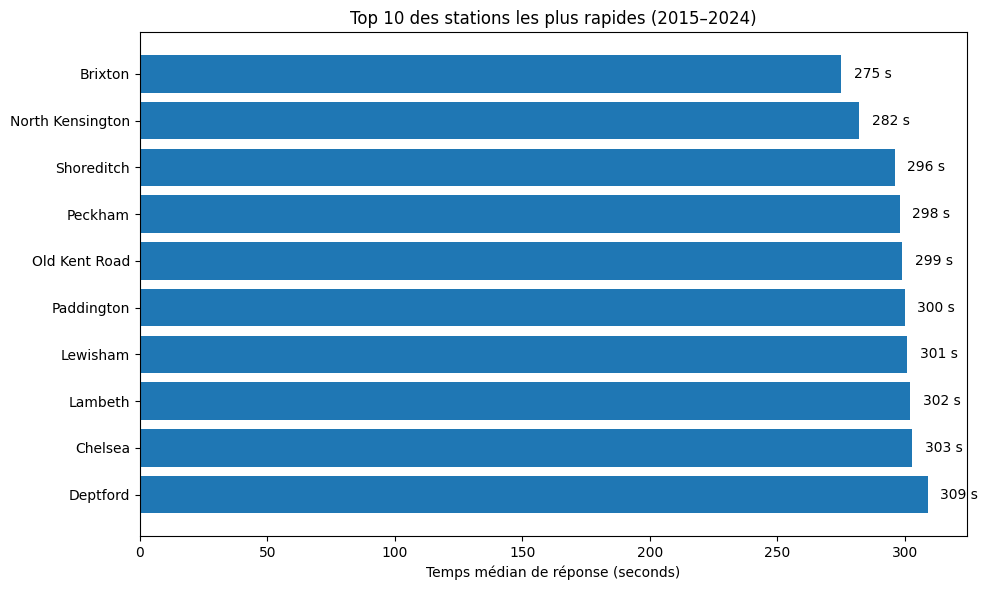

In [17]:
plt.figure(figsize=(10, 6))
plt.barh(top10["StationName"], top10["median_att"])
plt.gca().invert_yaxis()
plt.title("Top 10 des stations les plus rapides (2015–2024)")
plt.xlabel("Temps médian de réponse (seconds)")

for i, v in enumerate(top10["median_att"]):
    plt.text(v + 5, i, f"{int(v)} s", va="center")

# Sauvegarde
savefig("Top_10_stations_les_plus_rapides.png")

plt.tight_layout()
plt.show()